# Carvana Image Masking Challenge - submission 1

Notebook used to train and optimize an image segmentation model. The model is based on the U-net model and is trained on the Carvana Image Masking Challenge dataset. The result will be submitted to Kaggle for evaluation.


Discription of model:

U-net implementation (depth = 6). The network was trained with a resolution of 640x960 (RGB) and data-augmentation was used during training. Training was stopped until dice coefficient on validation set (20% of total train data) didn't improve anymore. Best weights are used. Keras.utils.Sequence was used to create the datagenerator and Google Colaboratory was used to train (GPU).


Private score on Kaggle: 0.99532 (DICE coefficient)

This notebook is mainly based on https://github.com/tensorflow/models/blob/master/samples/outreach/blogs/segmentation_blogpost/image_segmentation.ipynb made by Raymond Yuan and https://github.com/afshinea/keras-data-generator made by Afshine Amidi.

### Install and import libraries, mount google drive account

In [1]:
!pip install kaggle

In [2]:
# Install ngrok
# See https://ngrok.com/ for details
# Idea to use ngrok to visualize Tensorboard in real-time came from Jannik Zürn
# https://colab.research.google.com/drive/1ISfhxFDntfOos7cOeT7swduSqzLEqyFn#scrollTo=z0DRPKl39290&forceEdit=true&offline=true&sandboxMode=true
!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
!unzip ngrok-stable-linux-amd64.zip

# Connect with my account
get_ipython().system_raw('./ngrok authtoken uFK9zSjNnQEU4kW1FFnv_KifWXBEEF4Xs3L8XgfV9')

--2019-05-13 09:33:09--  https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
Resolving bin.equinox.io (bin.equinox.io)... 35.172.177.65, 52.72.145.109, 52.72.245.79, ...
Connecting to bin.equinox.io (bin.equinox.io)|35.172.177.65|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16529980 (16M) [application/octet-stream]
Saving to: ‘ngrok-stable-linux-amd64.zip.1’

ngrok-stable-linux- 100%[===================>]  15.76M  39.4MB/s    in 0.4s    

2019-05-13 09:33:10 (39.4 MB/s) - ‘ngrok-stable-linux-amd64.zip.1’ saved [16529980/16529980]

Archive:  ngrok-stable-linux-amd64.zip
replace ngrok? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: ngrok                   


In [3]:
# Show Python version
import platform
print(platform.python_version())

3.6.7


In [4]:
import os
import zipfile
import re
from tqdm import tqdm
import csv

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['axes.grid'] = False
mpl.rcParams['figure.figsize'] = (12,12)

from sklearn.model_selection import train_test_split
from skimage.transform import resize
import matplotlib.image as mpimg
from PIL import Image
from google.colab import drive
from google.colab import files
from pytz import timezone
from datetime import datetime

import tensorflow as tf
from tensorflow.python.keras import layers
from tensorflow.python.keras import losses
from tensorflow.python.keras import models
from tensorflow.python.keras import backend as K
from tensorflow.keras.callbacks import Callback
from tensorflow.python.keras.preprocessing import image
from tensorflow.python.keras.preprocessing.image import *

drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


### Download and extract training data

In [0]:
# Upload the API token so that we can use the Kaggle API.
def get_kaggle_credentials():
  token_dir = os.path.join(os.path.expanduser("~"),".kaggle")
  token_file = os.path.join(token_dir, "kaggle.json")
  if not os.path.isdir(token_dir):
    os.mkdir(token_dir)
  try:
    with open(token_file,'r') as f:
      pass
  except IOError as no_file:
    try:
      from google.colab import files
    except ImportError:
      raise no_file
    
    uploaded = files.upload()
    
    if "kaggle.json" not in uploaded:
      raise ValueError("You need an API key! see: "
                       "https://github.com/Kaggle/kaggle-api#api-credentials")
    with open(token_file, "wb") as f:
      f.write(uploaded["kaggle.json"])
    os.chmod(token_file, 600)

get_kaggle_credentials()

import kaggle

In [0]:
# Download data from Kaggle and unzip the files of interest (~25GB needed).
# You must accept the competition rules before downloading the data.
competition_name = 'carvana-image-masking-challenge'

def load_data_from_zip(competition, file):
  with zipfile.ZipFile(os.path.join(competition, file), "r") as zip_ref:
    zip_ref.extractall(competition)

def get_data(competition):
    kaggle.api.competition_download_files(competition, competition)
    load_data_from_zip(competition, 'train.zip')
    load_data_from_zip(competition, 'train_masks.zip')

# Data is stored in /content/carvana-image-masking-challenge
get_data(competition_name)

# or use: #!kaggle competitions download -c carvana-image-masking-challenge 
# -p /content/carvana-image-masking-challenge

In [7]:
# Show content of downloaded directory
directory = ""
dirs = os.listdir( os.path.join(competition_name,directory) )

# Print all the files and directories
for file in dirs:
   print(file)

train_masks.zip
29bb3ece3180_11.jpg
train_hq.zip
train_masks.csv.zip
test
sample_submission.csv.zip
train_masks
train.zip
test.zip
metadata.csv.zip
train
test_hq.zip


### Split the data in train and validation set and visualize the data

In [8]:
# Save path to images and masks
img_dir = os.path.join(competition_name, "train")
label_dir = os.path.join(competition_name, "train_masks")

# Make a list of all car ID's (remove duplicates)
carIDs = [re.split('_',file)[0] for file in os.listdir(img_dir)]
carIDs = sorted(set(carIDs))

# Split data in train (64%), validation (18%) and test (18%) set
carIDs_train, carIDs_validation = train_test_split(carIDs, test_size=0.2, random_state=42)
carIDs_validation, carIDs_test = train_test_split(carIDs_validation, test_size=0., random_state=42)

# Create list of full filenames for train, validation and test set
x_train_filenames, y_train_filenames = [], []
x_validation_filenames, y_validation_filenames = [], []
x_test_filenames, y_test_filenames = [], []

for img_id in os.listdir(img_dir):
  img_id = os.path.splitext(img_id)[0]
  if re.split('_',img_id)[0] in carIDs_train:
    x_train_filenames.append(os.path.join(img_dir, "{}.jpg".format(img_id)))
    y_train_filenames.append(os.path.join(label_dir, "{}_mask.gif".format(img_id)))
  elif re.split('_',img_id)[0] in carIDs_validation:
    x_validation_filenames.append(os.path.join(img_dir, "{}.jpg".format(img_id)))
    y_validation_filenames.append(os.path.join(label_dir, "{}_mask.gif".format(img_id)))
  elif re.split('_',img_id)[0] in carIDs_test:
    x_test_filenames.append(os.path.join(img_dir, "{}.jpg".format(img_id)))
    y_test_filenames.append(os.path.join(label_dir, "{}_mask.gif".format(img_id)))

num_train_examples = len(x_train_filenames)
num_validation_examples = len(x_validation_filenames)
num_test_examples = len(x_test_filenames)

print("Number of training examples: {}".format(num_train_examples))
print("Number of validation examples: {}".format(num_validation_examples))
print("Number of test examples: {}".format(num_test_examples))

# Show example of filenames
print(x_train_filenames[:3])
print(y_train_filenames[:3])

Number of training examples: 4064
Number of validation examples: 1024
Number of test examples: 0
['carvana-image-masking-challenge/train/bad53871c7d9_15.jpg', 'carvana-image-masking-challenge/train/2a4a8964ebf3_01.jpg', 'carvana-image-masking-challenge/train/fff9b3a5373f_07.jpg']
['carvana-image-masking-challenge/train_masks/bad53871c7d9_15_mask.gif', 'carvana-image-masking-challenge/train_masks/2a4a8964ebf3_01_mask.gif', 'carvana-image-masking-challenge/train_masks/fff9b3a5373f_07_mask.gif']


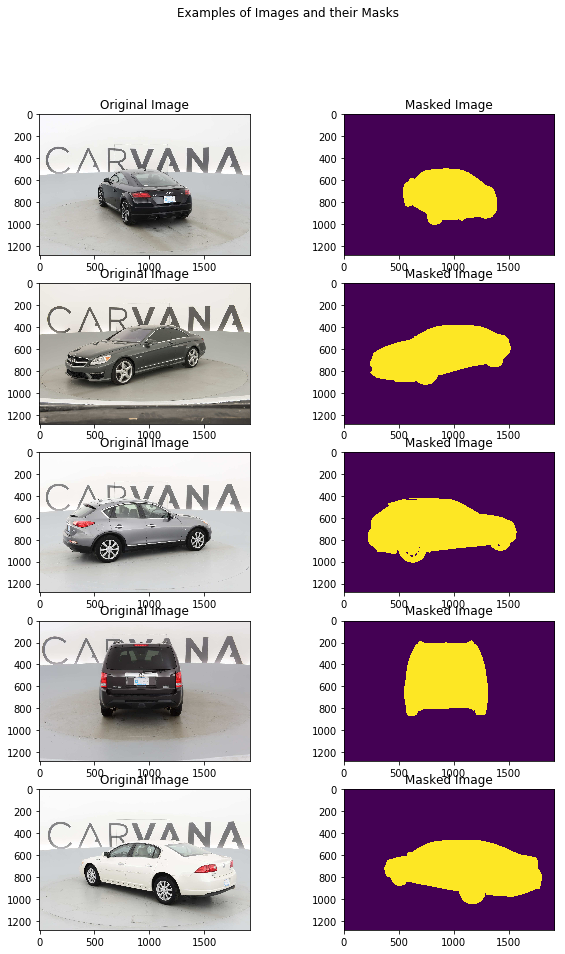

In [9]:
# Visualize the data
display_num = 5

r_choices = np.random.choice(num_train_examples, display_num)

plt.figure(figsize=(10, 15))
for i in range(0, display_num * 2, 2):
  img_num = r_choices[i // 2]
  x_pathname = x_train_filenames[img_num]
  y_pathname = y_train_filenames[img_num]
  
  plt.subplot(display_num, 2, i + 1)
  plt.imshow(mpimg.imread(x_pathname))
  plt.title("Original Image")
  
  example_labels = Image.open(y_pathname)
  label_vals = np.unique(example_labels)
  
  plt.subplot(display_num, 2, i + 2)
  plt.imshow(example_labels)
  plt.title("Masked Image")  
  
plt.suptitle("Examples of Images and their Masks")
plt.show()

In [0]:
# Check if the resolution of all the images is 1280*1918
for img in tqdm(x_train_filenames + x_validation_filenames + x_test_filenames):
  X = image.load_img(img)
  if np.shape(X) != (1280, 1918, 3):
    print('Image with different size found!')

100%|██████████| 5088/5088 [02:27<00:00, 34.45it/s]


### Set trainings settings

In [0]:
img_shape = (640, 960, 3) # Both the width and height should be divisable by 64
batch_size = 4
epochs = 45
num_workers = 4

### Build the model

In [0]:
# First declare some helper functions
def conv_block(input_tensor, num_filters):
  encoder = layers.Conv2D(num_filters, (3, 3), padding='same')(input_tensor)
  encoder = layers.BatchNormalization()(encoder)
  encoder = layers.Activation('relu')(encoder)
  encoder = layers.Conv2D(num_filters, (3, 3), padding='same')(encoder)
  encoder = layers.BatchNormalization()(encoder)
  encoder = layers.Activation('relu')(encoder)
  return encoder

def encoder_block(input_tensor, num_filters):
  encoder = conv_block(input_tensor, num_filters)
  encoder_pool = layers.MaxPooling2D((2, 2), strides=(2, 2))(encoder)
  
  return encoder_pool, encoder

def decoder_block(input_tensor, concat_tensor, num_filters):
  decoder = layers.Conv2DTranspose(num_filters, (2, 2), strides=(2, 2), padding='same')(input_tensor)
  decoder = layers.concatenate([concat_tensor, decoder], axis=-1)
  decoder = layers.BatchNormalization()(decoder)
  decoder = layers.Activation('relu')(decoder)
  decoder = layers.Conv2D(num_filters, (3, 3), padding='same')(decoder)
  decoder = layers.BatchNormalization()(decoder)
  decoder = layers.Activation('relu')(decoder)
  decoder = layers.Conv2D(num_filters, (3, 3), padding='same')(decoder)
  decoder = layers.BatchNormalization()(decoder)
  decoder = layers.Activation('relu')(decoder)
  return decoder

# Build the actual model, layer by layer
inputs = layers.Input(shape=img_shape)
# 640*960

encoder0_pool, encoder0 = encoder_block(inputs, 16)
# 320*480

encoder1_pool, encoder1 = encoder_block(encoder0_pool, 32)
# 160*240

encoder2_pool, encoder2 = encoder_block(encoder1_pool, 64)
# 80*120

encoder3_pool, encoder3 = encoder_block(encoder2_pool, 128)
# 40*60

encoder4_pool, encoder4 = encoder_block(encoder3_pool, 256)
# 20*30

encoder5_pool, encoder5 = encoder_block(encoder4_pool, 512)
# 10*15

center = conv_block(encoder5_pool, 1024)
# center

decoder5 = decoder_block(center, encoder5, 512)
# 20*30

decoder4 = decoder_block(decoder5, encoder4, 256)
# 40*60

decoder3 = decoder_block(decoder4, encoder3, 128)
# 80*120

decoder2 = decoder_block(decoder3, encoder2, 64)
# 160*240

decoder1 = decoder_block(decoder2, encoder1, 32)
# 320*480

decoder0 = decoder_block(decoder1, encoder0, 16)
# 640*960

outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(decoder0)

# Define the model by specifying the input and output
model = models.Model(inputs=[inputs], outputs=[outputs])

Instructions for updating:
Colocations handled automatically by placer.


### Define loss and metric functions

In [0]:
# Define metrics and loss functions
def dice_coeff(y_true, y_pred):
    smooth = 0.
    # Flatten and classify every pixel (<= 0.5 -> background, > 0.5 -> foreground)
    y_true_f = tf.round(tf.reshape(y_true, [-1]))
    y_pred_f = tf.round(tf.reshape(y_pred, [-1]))
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    score = (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + 
                                            tf.reduce_sum(y_pred_f) + smooth)
    return score
  
def dice_loss(y_true, y_pred):
    smooth = 0.
    # Flatten
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    score = (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) +
                                            tf.reduce_sum(y_pred_f) + smooth)
    loss = 1 - score
    return loss

def bce_dice_loss(y_true, y_pred):
    #loss = losses.binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)
    #loss = tf.keras.backend.binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)
    #loss = -1/tf.size(y_true)*tf.math.reduce_sum(y_true*tf.math.log(y_pred) + 
    #                             (1-y_true)*tf.math.log(1-y_pred))
    loss = tf.keras.backend.binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)
    return loss

### Build datagenerator using tf.keras.utils.Sequence (with data-augmentation)

In [0]:
class DataGenerator(tf.keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, x_paths, y_paths, batch_size=32, x_shape=(128,128,3), scale=1.,
                 horizontal_flip=False, vertical_flip=False, shift_range=None, 
                 rotation_range=0, shear_range=0, zoom_range=0, brightness_range=0,
                 hue_shift_range=0, shuffle=True, drop_remainder=True):
        'Initialization'
        self.x_shape = x_shape
        self.batch_size = batch_size
        self.x_paths = x_paths
        self.y_paths = y_paths
        self.shuffle = shuffle
        self.scale = scale
        self.horizontal_flip = horizontal_flip
        self.vertical_flip = vertical_flip
        self.shift_range = shift_range
        if shift_range is not None:
          self.width_shift_range = 2*shift_range[0]/(2*np.sqrt(2*np.log(2)))
          self.height_shift_range = 2*shift_range[1]/(2*np.sqrt(2*np.log(2)))
        self.rotation_range = 2*rotation_range/(2*np.sqrt(2*np.log(2)))
        self.shear_range = 2*shear_range/(2*np.sqrt(2*np.log(2)))
        self.zoom_range = 2*zoom_range/(2*np.sqrt(2*np.log(2)))
        self.brightness_range = 2*brightness_range/(2*np.sqrt(2*np.log(2)))
        self.hue_shift_range = 2*hue_shift_range/(2*np.sqrt(2*np.log(2)))
        self.drop_remainder = drop_remainder
        self.on_epoch_end()
        
        if np.mod(len(self.x_paths), self.batch_size) != 0:
          print(f'Warning, {np.mod(len(self.x_paths), self.batch_size)} sample(s) are not used in an epoch')

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.x_paths) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Generate data
        X, Y = self.__load_data(indexes)
        
        #Do augmentation
        # See: https://github.com/keras-team/keras-preprocessing/blob/master/keras_preprocessing/image/affine_transformations.py
        X = X*self.scale
        if self.y_paths is not None:
          Y = Y*self.scale
        if self.brightness_range:
          X = self.__apply_brightness_shift_rand(X)
        if self.hue_shift_range:
          X = self.__apply_hue_shift_rand(X)
        X, Y = self.__flip_img_hor_rand(X, Y)
        X, Y = self.__flip_img_ver_rand(X, Y)
        if self.zoom_range:
          X, Y = self.__zoom_img_rand(X, Y)
        if self.shift_range is not None:
          X, Y = self.__shift_img_rand(X, Y)
        if self.rotation_range:
          X, Y = self.__rotation_img_rand(X, Y)
        if self.shear_range:
          X, Y = self.__shear_img_rand(X, Y)
        
        return X, Y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.x_paths))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __load_data(self, indexes):
        'Generates data containing batch_size samples' # X : (n_samples, x_shape)
        # Initialization
        X = np.empty((self.batch_size, *self.x_shape))
        if self.y_paths is not None:
          Y = np.empty((self.batch_size, self.x_shape[0], self.x_shape[1], 1))
        else:
          # If self.y_paths is None, Y will contain the path to the returned images. This
          # is used to create the .csv file which will be submitted to Kaggle.
          Y = [self.x_paths[i] for i in indexes]

        # Generate data
        for i, ID in enumerate(indexes):
            # Store sample
            X[i,] = image.load_img(self.x_paths[ID],
                      target_size=(self.x_shape[0],self.x_shape[1]))

            # Store label
            if self.y_paths is not None:
              Y[i,:,:,0] = image.load_img(self.y_paths[ID],
                        target_size=(self.x_shape[0],self.x_shape[1]), color_mode = "grayscale")
            
        return X, Y
      
    def __flip_img_hor_rand(self, x, y):
        if self.horizontal_flip:
          for ii in range(x.shape[0]):
            flip_prob = np.random.rand()
            if flip_prob <= 0.5:
              x[ii] = np.flip(x[ii], axis=1)
              y[ii] = np.flip(y[ii], axis=1)
        return x, y
      
    def __flip_img_ver_rand(self, x, y):
        if self.vertical_flip:
          for ii in range(x.shape[0]):
            flip_prob = np.random.rand()
            if flip_prob <= 0.5:
              x[ii] = np.flip(x[ii], axis=0)
              y[ii] = np.flip(y[ii], axis=0)
        return x, y
      
    def __shift_img_rand(self, x, y, row_axis=1, col_axis=2, channel_axis=3,
                 fill_mode='nearest', cval=0., interpolation_order=1):
        # From https://github.com/keras-team/keras-preprocessing/blob/master/keras_preprocessing/image/affine_transformations.py
        # When self.shift_range = (0.,0.), no shift will be applied
        h, w = x.shape[row_axis], x.shape[col_axis]
        for ii in range(x.shape[0]):
          tx = np.random.normal(loc=0., scale=self.height_shift_range) * h
          ty = np.random.normal(loc=0., scale=self.width_shift_range) * w
          x[ii] = apply_affine_transform(x[ii], tx=tx, ty=ty, channel_axis=channel_axis-1,
                               fill_mode=fill_mode, cval=cval, order=interpolation_order)
          y[ii] = apply_affine_transform(y[ii], tx=tx, ty=ty, channel_axis=channel_axis-1,
                               fill_mode=fill_mode, cval=cval, order=interpolation_order)
        return x, y
      
    def __rotation_img_rand(self, x, y, row_axis=1, col_axis=2, channel_axis=3,
                 fill_mode='nearest', cval=0., interpolation_order=1):
        for ii in range(x.shape[0]):
          theta = np.random.normal(loc=0., scale=self.rotation_range)
          x[ii] = apply_affine_transform(x[ii], theta=theta, channel_axis=channel_axis-1,
                               fill_mode=fill_mode, cval=cval, order=interpolation_order)
          y[ii] = apply_affine_transform(y[ii], theta=theta, channel_axis=channel_axis-1,
                               fill_mode=fill_mode, cval=cval, order=interpolation_order)
        return x, y
      
    def __shear_img_rand(self, x, y, row_axis=1, col_axis=2, channel_axis=3,
                 fill_mode='nearest', cval=0., interpolation_order=1):
        for ii in range(x.shape[0]):
          shear = np.random.normal(loc=0., scale=self.shear_range)
          x[ii] = apply_affine_transform(x[ii], shear=shear, channel_axis=channel_axis-1,
                               fill_mode=fill_mode, cval=cval, order=interpolation_order)
          y[ii] = apply_affine_transform(y[ii], shear=shear, channel_axis=channel_axis-1,
                               fill_mode=fill_mode, cval=cval, order=interpolation_order)
        return x, y
    
    def __zoom_img_rand(self, x, y, row_axis=1, col_axis=2, channel_axis=3,
                 fill_mode='nearest', cval=0., interpolation_order=1):
      # When self.zoom_range = (1, 1), no zoom will be applied
        for ii in range(x.shape[0]):
          zx, zy = np.random.normal(loc=1., scale=self.zoom_range, size=2)
          x[ii] = apply_affine_transform(x[ii], zx=zx, zy=zy, channel_axis=channel_axis-1,
                               fill_mode=fill_mode, cval=cval, order=interpolation_order)
          y[ii] = apply_affine_transform(y[ii], zx=zx, zy=zy, channel_axis=channel_axis-1,
                               fill_mode=fill_mode, cval=cval, order=interpolation_order)
        return x, y
    
    def __apply_brightness_shift_rand(self, x):
      # When self.brightness_range = (1, 1), the brightness will stay the same
        for ii in range(x.shape[0]):
          u = np.random.normal(loc=1., scale=self.brightness_range)
          x[ii] = apply_brightness_shift(x[ii]*255, u)
        return x/255.
    
    def __apply_hue_shift_rand(self, x):
        for ii in range(x.shape[0]):
          u = np.random.normal(loc=0., scale=self.hue_shift_range)
          x[ii] = mpl.colors.rgb_to_hsv(x[ii])
          x[ii,:,:,0] = np.mod(x[ii,:,:,0]+u,1)
          x[ii] = mpl.colors.hsv_to_rgb(x[ii])
        return x

In [0]:
# Setup the train and validation datagenerators
params_train = {'batch_size': batch_size,
                'x_shape': img_shape,
                'scale': 1/255.,
                'horizontal_flip': True,
                'vertical_flip': False,
                'shift_range': (0.1, 0.1),
                'rotation_range': 4., #degree
                'shear_range': 2., #degree
                'zoom_range': 0.1,
                'brightness_range': 0.1, 
                'hue_shift_range': 0.12,
                'shuffle': True,
                'drop_remainder': True}
params_val = {'batch_size': batch_size,
              'x_shape': img_shape,
              'scale': 1/255.,
              'shuffle': False}

training_generator = DataGenerator(x_train_filenames,y_train_filenames, **params_train)
training_generator_no_augmentation = DataGenerator(x_train_filenames,y_train_filenames, **params_val)
validation_generator = DataGenerator(x_validation_filenames,y_validation_filenames, **params_val)
test_generator = DataGenerator(x_test_filenames,y_test_filenames, **params_val)

(4, 640, 960, 3)
(4, 640, 960, 1)
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


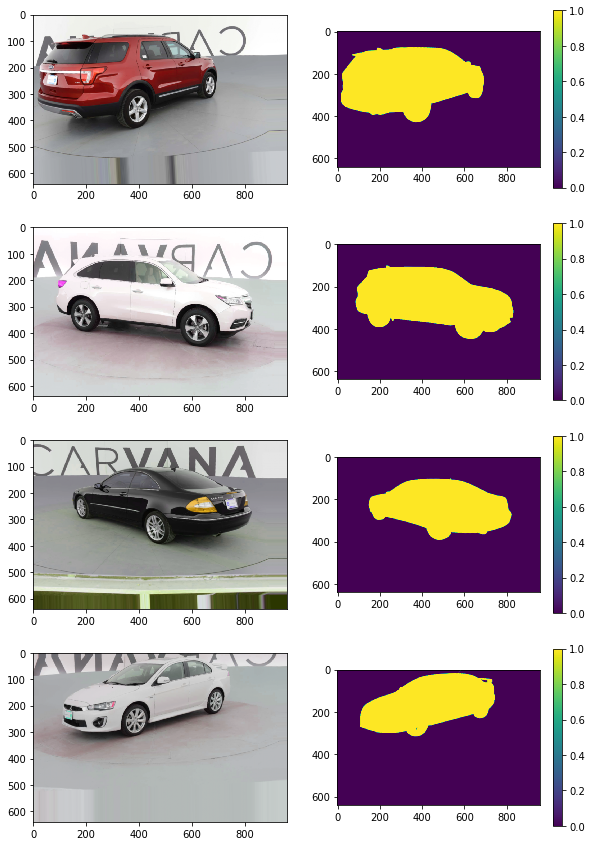

In [14]:
# Visualize the working of our datagenerator
my_iter = iter(training_generator)

img, img_lab = next(my_iter)
print(img.shape)
print(img_lab.shape)
print(type(img))
print(type(img_lab))

plt.figure(figsize=(10,15))
for i in range(img.shape[0]):
  plt.subplot(img.shape[0],2,2*i+1)
  plt.imshow(img[i])
  plt.subplot(img.shape[0],2,2*i+2)
  plt.imshow(img_lab[i,:,:,0])
  plt.colorbar()

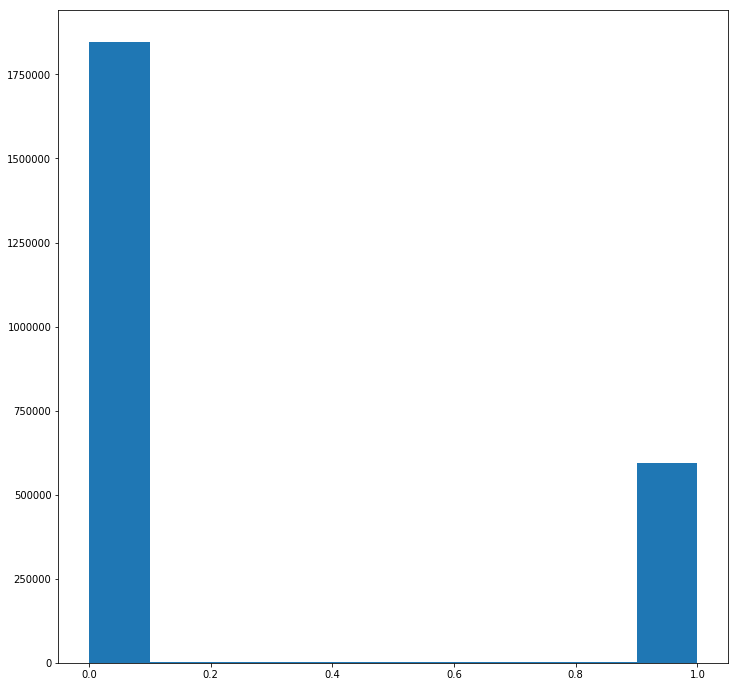

In [15]:
# Check the distribution of background vs foreground
plt.hist(img_lab[:,:,:,0].flatten());

### Train the model using the tf.keras.utils.Sequence datagenerator

In [16]:
# Launch ngrok
# kill all running ngrok instances
!pkill -f ngrok

# Execute tensorboard
#!rm rf /tmp/checkpoints # Remove folder
# I think should be !rm-rf /tmp/checkpoints
!rm rf /tmp/checkpoints
!mkdir /tmp/checkpoints
LOG_DIR = '/tmp/checkpoints/'
get_ipython().system_raw(
    f'tensorboard --logdir {LOG_DIR} --host 0.0.0.0 --port 6006 &'
)

# execute ngrok
get_ipython().system_raw('./ngrok http 6006 &')

# Do the tunneling
!curl -s http://localhost:4040/api/tunnels | python3 -c \
    "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"

rm: cannot remove 'rf': No such file or directory
rm: cannot remove '/tmp/checkpoints': Is a directory
mkdir: cannot create directory ‘/tmp/checkpoints’: File exists
https://092b654c.ngrok.io


In [0]:
save_files_dir = '/content/gdrive/My Drive/Google Colaboratory/Carvana first succesful submission'
version = 3

save_model_path = os.path.join(save_files_dir, f'Carvana_Image_Segmentation_v{version}.hdf5')
save_model_backup_path = os.path.join(save_files_dir, f'Carvana_Image_Segmentation_backup_v{version}.hdf5')
save_history_path = os.path.join(save_files_dir, f'Carvana_Image_Segmentation_v{version}.npy')
save_history_txt_path = os.path.join(save_files_dir, f'Carvana_Image_Segmentation_v{version}.txt')

# Compile the model and show summary
#model.compile(optimizer='adam', loss=bce_dice_loss, metrics=[dice_coeff])

#model.summary()

# Create callback to calculate metric at the end of an epoch
class AccuracyHistory(Callback):
    def __init__(self, train_generator, validation_generator, test_generator):
      self.train_generator = train_generator
      self.validation_generator = validation_generator
      self.test_generator = test_generator
      self.myHistory = {b"train_loss_from_logs": [], b"train_dice_coeff_from_logs": [],
                        b"train_loss": [], b"train_dice_coeff": [], b"val_loss": [],
                        b"val_dice_coeff": [], b"test_loss": 0., b"test_dice_coeff": 0.}
      self.zone = timezone('Europe/Amsterdam')
      
    def resume_training(self, path_to_history):
      self.myHistory = np.load(path_to_history, allow_pickle=True).item()
      print(self.myHistory)
    
    def on_train_begin(self, logs=None):
      with open(save_history_txt_path, 'a+') as f:
        f.write(f'Training started at: {datetime.now(self.zone)}\n\n')
    
    def on_epoch_end(self, epoch, logs=None):
      train_result = self.model.evaluate_generator(self.train_generator, verbose=1,
                                                     use_multiprocessing=True, workers=num_workers)
      self.myHistory[b"train_loss"].append(train_result[0])
      self.myHistory[b"train_dice_coeff"].append(train_result[1])
      
      self.myHistory[b"train_loss_from_logs"].append(logs["loss"])
      self.myHistory[b"train_dice_coeff_from_logs"].append(logs["dice_coeff"])
      
      self.myHistory[b"val_loss"].append(logs["val_loss"])
      self.myHistory[b"val_dice_coeff"].append(logs["val_dice_coeff"])
      
      self.model.save(save_model_backup_path)
      np.save(save_history_path, self.myHistory)
      
      with open(save_history_txt_path, 'a+') as f:
        f.write(f'-----------------------Epoch {epoch + 1}-----------------------\n')
        f.write(f'Epoch finished at: {datetime.now(self.zone)}\n')
        f.write(f'Train_loss_from_logs: {self.myHistory[b"train_loss_from_logs"][-1]}, Train_dice_coeff_from_logs: {self.myHistory[b"train_dice_coeff_from_logs"][-1]}\n')
        f.write(f'Train_loss: {self.myHistory[b"train_loss"][-1]}, Train_dice_coeff: {self.myHistory[b"train_dice_coeff"][-1]}\n')
        f.write(f'Val_loss: {self.myHistory[b"val_loss"][-1]}, Val_dice_coeff: {self.myHistory[b"val_dice_coeff"][-1]}\n\n')
        
    def on_train_end(self, logs=None):
      self.model = models.load_model(save_model_path, custom_objects={'bce_dice_loss': bce_dice_loss,
                                                           'dice_coeff': dice_coeff})
      test_result = self.model.evaluate_generator(self.test_generator, verbose=1,
                                                     use_multiprocessing=True, workers=num_workers)
      self.myHistory[b"test_loss"] = test_result[0]
      self.myHistory[b"test_dice_coeff"] = test_result[1]
      np.save(save_history_path, self.myHistory)
      
      with open(save_history_txt_path, 'a+') as f:
        f.write(f'Test_loss: {self.myHistory[b"test_loss"]}, Test_dice_coeff: {self.myHistory[b"test_dice_coeff"]}\n')
        f.write(f'Training finished at: {datetime.now(self.zone)}')
      
accuracyHistogram = AccuracyHistory(training_generator_no_augmentation, validation_generator, test_generator)

# Define callbacks
cp = [tf.keras.callbacks.ModelCheckpoint(filepath=save_model_path, monitor='val_dice_coeff', 
                                         save_best_only=True, mode='max', verbose=1), 
     accuracyHistogram, tf.keras.callbacks.TensorBoard(log_dir=LOG_DIR)]

### Train the model

In [0]:
# Start training and keep track of training time
%%time

# Start time 00:20
history = model.fit_generator(generator=training_generator,
                   validation_data=validation_generator,
                   epochs=epochs,
                   use_multiprocessing=True,
                   workers=num_workers,
                   callbacks=cp)

Instructions for updating:
Use tf.cast instead.
Epoch 1/32
256/256 [==============================] - 188s 733ms/step - loss: 3.3219 - dice_coeff: 0.7838

Epoch 00001: val_dice_coeff improved from -inf to 0.78375, saving model to /content/gdrive/My Drive/Google Colaboratory/Models/Carvana_Image_Segmentation_v3.hdf5
1016/1016 [==============================] - 4447s 4s/step - loss: 0.5728 - dice_coeff: 0.9638 - val_loss: 3.3219 - val_dice_coeff: 0.7838
Epoch 2/32
 963/1016 [===========================>..] - ETA: 3:12 - loss: 0.1653 - dice_coeff: 0.9853

In [0]:
# Continue training from epoch 36
model = models.load_model(save_model_backup_path, custom_objects={'bce_dice_loss': bce_dice_loss,
                                                           'dice_coeff': dice_coeff})
accuracyHistogram.resume_training(save_history_path)

model.fit_generator(generator=training_generator,
                   validation_data=validation_generator,
                   epochs=epochs,
                   use_multiprocessing=True,
                   workers=num_workers,
                   callbacks=cp,
                   initial_epoch=36)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
{b'train_loss_from_logs': [0.5727582933953194, 0.16367208844006764, 0.149115156726985, 0.175549440855879, 0.10705743935032505, 0.09872975783407922, 0.08774486196953363, 0.07798685682350844, 0.08388856442381196, 0.08285735863238924, 0.07321838095168194, 0.06867688413210742, 0.08213927563441199, 0.08038835913881542, 0.06580972854473342, 0.06505824119864603, 0.06396866087823755, 0.0660921101289706, 0.06338939852792565, 0.06273654620273142, 0.07010713928034455, 0.06785518065549609, 0.058977636647975354, 0.060188009550310964, 0.06252397806567, 0.05916388110646347, 0.05802930477185277, 0.057010410745870176, 0.059090818439822966, 0.05670697984512983, 0.05736960154613407, 0.062175988986002885, 0.05709432553514603, 0.05522137348664793, 0.06001421583699077, 0.056472341141362827], b'train_dice_coeff_from_logs': [0.96377, 0.9854638, 0.9867279, 0.98377323, 0.99054146, 0.99133027, 

### Load the best model and train history, plot the train history

In [18]:
# Load model and train history
model = models.load_model(save_model_path, custom_objects={'bce_dice_loss': bce_dice_loss,
                                                           'dice_coeff': dice_coeff})

History = np.load(save_history_path, allow_pickle=True).item()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


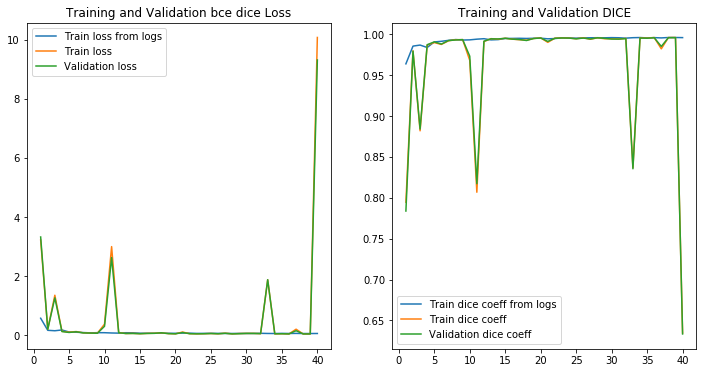

In [19]:
# Plot train history
epochs_range = np.arange(len(History[b'train_loss']))+1

# Loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, History[b'train_loss_from_logs'], label='Train loss from logs')
plt.plot(epochs_range, History[b'train_loss'], label='Train loss')
plt.plot(epochs_range, History[b'val_loss'], label='Validation loss')
plt.legend(loc='upper left')
plt.title('Training and Validation bce dice Loss')

# Dice
plt.subplot(1, 2, 2)
plt.plot(epochs_range, History[b'train_dice_coeff_from_logs'], label='Train dice coeff from logs')
plt.plot(epochs_range, History[b'train_dice_coeff'], label='Train dice coeff')
plt.plot(epochs_range, History[b'val_dice_coeff'], label='Validation dice coeff')
plt.legend(loc='lower left')
plt.title('Training and Validation DICE')

plt.show()

### Check DICE on validation set

In [0]:
# Calculate DICE on validation set with downsized resolution
validation_result_low_resolution = model.evaluate_generator(validation_generator, verbose=1,
                                                     use_multiprocessing=True, workers=num_workers)
print(validation_result_low_resolution)

256/256 [==============================] - 87s 342ms/step - loss: 0.0414 - dice_coeff: 0.9958
[0.04135408883303171, 0.9957886]


In [0]:
# Calculate DICE manually (downsized resolution)
# Build validation graph
pred = tf.placeholder(tf.float32, shape=(4, img_shape[0], img_shape[1], 1))
lab = tf.placeholder(tf.float32, shape=(4, img_shape[0], img_shape[1], 1))
dice_low_res = dice_coeff(lab,pred)

# Run validation graph
DICE_low_res = []
sess = tf.Session()
it = iter(validation_generator)
for i in tqdm(range(len(validation_generator))):
  img = next(it)
  prediction = model.predict_on_batch(img[0])
  DICE_low_res.append(sess.run(dice_low_res, feed_dict={pred: prediction,
                                                        lab: img[1].astype('float32')}));
sess.close()

print(f'\nDice coefficient on validation set (downsized resolution): {np.mean(DICE_low_res)}')

100%|██████████| 256/256 [01:45<00:00,  2.65it/s]


Dice coefficient on validation set (downsized resolution): 0.9957886338233948


In [0]:
# Create datagenerator for validation dataset (full resolution)
params_val_full_resolution = {'batch_size': batch_size,
              'x_shape': (1280, 1918, 3),
              'scale': 1/255.,
              'shuffle': False}

validation_generator_full_res = DataGenerator(x_validation_filenames,y_validation_filenames, **params_val_full_resolution)

In [0]:
# Calculate DICE manually (full resolution)
# Build validation graph
pred = tf.placeholder(tf.float32, shape=(4, 1280, 1918, 1))
lab = tf.placeholder(tf.float32, shape=(4, 1280, 1918, 1))
dice_full_res = dice_coeff(lab,pred)

# Run validation graph
DICE_full_res = []
sess = tf.Session()
it = iter(validation_generator)
it_full_res = iter(validation_generator_full_res)
for i in tqdm(range(len(validation_generator))):
  img = next(it)
  prediction = model.predict_on_batch(img[0])
  prediction_full_res = np.empty((4, 1280, 1918, 1), dtype=np.float32)
  for i in range(prediction.shape[0]):
    prediction_full_res[i] = resize(prediction[i],(1280,1918))
  mask = next(it_full_res)
  DICE_full_res.append(sess.run(dice_full_res, feed_dict={pred: prediction_full_res,
                                                          lab: mask[1].astype('float32')}));
sess.close()

print(f'\nDice coefficient on validation set (full resolution): {np.mean(DICE_full_res)}')

  0%|          | 0/256 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
100%|██████████| 256/256 [04:57<00:00,  1.13s/it]


Dice coefficient on validation set (full resolution): 0.9955689907073975


### Predict the test set and submit result to Kaggle

In [0]:
# Unpack the test data
load_data_from_zip(competition_name, 'test.zip')

In [21]:
# Save path to images and masks
test_dir = os.path.join(competition_name, "test")

# Create list of full filenames for train, validation and test set
x_submission_filenames = []

for img_id in os.listdir(test_dir):
  x_submission_filenames.append(os.path.join(test_dir, img_id))
  
x_submission_filenames = sorted(x_submission_filenames)

num_submission_examples = len(x_submission_filenames)

print("Number of submission examples: {}".format(num_submission_examples))

# Show example of filenames
print(x_submission_filenames[:6])

# Build datagenerator
params_val = {'batch_size': batch_size,
              'x_shape': img_shape,
              'scale': 1/255.,
              'shuffle': False}
submission_generator = DataGenerator(x_submission_filenames, None, **params_val)

Number of submission examples: 100064
['carvana-image-masking-challenge/test/0004d4463b50_01.jpg', 'carvana-image-masking-challenge/test/0004d4463b50_02.jpg', 'carvana-image-masking-challenge/test/0004d4463b50_03.jpg', 'carvana-image-masking-challenge/test/0004d4463b50_04.jpg', 'carvana-image-masking-challenge/test/0004d4463b50_05.jpg', 'carvana-image-masking-challenge/test/0004d4463b50_06.jpg']


(4, 640, 960, 3)
(4,)
<class 'numpy.ndarray'>
<class 'list'>
['carvana-image-masking-challenge/test/0004d4463b50_01.jpg', 'carvana-image-masking-challenge/test/0004d4463b50_02.jpg', 'carvana-image-masking-challenge/test/0004d4463b50_03.jpg', 'carvana-image-masking-challenge/test/0004d4463b50_04.jpg']


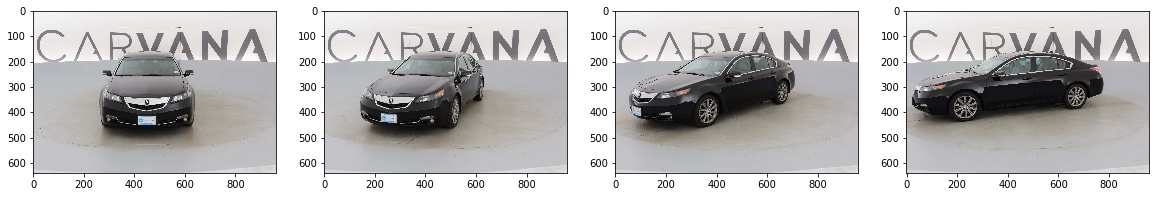

In [22]:
# Visualize the working of our submission datagenerator
my_iter = iter(submission_generator)

img, img_lab = next(my_iter)
print(img.shape)
print(np.shape(img_lab))
print(type(img))
print(type(img_lab))
print(img_lab)

plt.figure(figsize=(20,5))
for i in range(img.shape[0]):
  plt.subplot(1,img.shape[0],i+1)
  plt.imshow(img[i])

/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


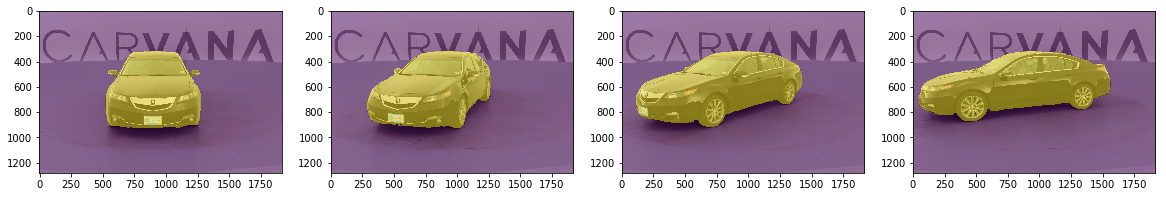

In [23]:
# Visualize the segmentation on the submission set (full resolution)

def image_show(image, prediction, index, nrows=1, ncols=4, cmap='gray', alpha=0.5, ax=None):
  # Show overlap between image and segmentation
  if ax is None:
    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 5))
  ax[index].imshow(image, cmap='gray')
  ax[index].imshow(prediction, alpha=alpha)
  return ax

# Build datagenerator (full resolution)
params_val_full_res = {'batch_size': batch_size,
                        'x_shape': (1280, 1918, 3),
                        'scale': 1/255.,
                        'shuffle': False}
submission_generator_full_res = DataGenerator(x_submission_filenames, None, **params_val_full_res)

# Create iterators
it = iter(submission_generator)
it_full_res = iter(submission_generator_full_res)

# Do prediction and resize to the original resolution
prediction = model.predict_on_batch(next(it)[0])
prediction_full_res = np.empty((4, 1280, 1918, 1), dtype=np.float32)
for i in range(prediction.shape[0]):
  prediction_full_res[i] = resize(prediction[i],(1280,1918))

# Show the segmentation in full resolution
img_full_res = next(it_full_res)[0]
ax = None
for i in range(prediction_full_res.shape[0]):
  ax = image_show(img_full_res[i,:,:,:], prediction_full_res[i,:,:,0] > 0.5, i, ax=ax)

In [0]:
# Function for run-length encoding (source: https://www.kaggle.com/hackerpoet/even-faster-run-length-encoder)
def rle(img):
  flat_img = img.flatten()
  flat_img = np.where(flat_img > 0.5, 1, 0).astype(np.uint8)
  flat_img = np.insert(flat_img, [0, len(flat_img)], [0, 0])

  starts = np.array((flat_img[:-1] == 0) & (flat_img[1:] == 1))
  ends = np.array((flat_img[:-1] == 1) & (flat_img[1:] == 0))
  starts_ix = np.where(starts)[0] + 1
  ends_ix = np.where(ends)[0] + 1
  lengths = ends_ix - starts_ix

  encoding = ''
  for idx in range(len(starts_ix)):
      encoding += '%d %d ' % (starts_ix[idx], lengths[idx])
  return encoding.strip()

In [25]:
# Create submission file (full resolution)
it = iter(submission_generator)
file_path = os.path.join(save_files_dir, f'Submission_file_v{version}.csv')

with open(file_path, 'w') as csvfile:
  writer = csv.DictWriter(csvfile, fieldnames=['img', 'rle_mask'])
  writer.writeheader()
  for i in tqdm(range(len(submission_generator))):
    img = next(it)
    prediction = model.predict_on_batch(img[0])
    for i in range(prediction.shape[0]):
      prediction_full_res = resize(prediction[i],(1280,1918))
      file_id = re.split('/',img[1][i])[-1]
      writer.writerow({'img': file_id, 'rle_mask': rle(prediction_full_res)})

  0%|          | 0/25016 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
100%|██████████| 25016/25016 [5:41:41<00:00,  1.26it/s]


In [0]:
# Submit to Kaggle
get_ipython().system_raw(
    f'kaggle competitions submit -c carvana-image-masking-challenge -f {file_path} -m "U-net implementation (depth = 6). The network was trained with a resolution of 640x960 (RGB) and data-augmentation was used during training. Training was stopped until dice coefficient on validation set (20% of total train data) didn\'t improve anymore. Best weights are used."'
)
